In [ ]:
%%html
<style>
    .gray {
        background-color: #dfe0e8;
    }
</style>

## The Reuters Corpus

<div class="gray">
Revisit the Reuters C50 text corpus that we briefly explored in class. Your task is simple: tell an interesting story,
anchored in some analytical tools we have learned in this class, using this data. For example:
    
- you could cluster authors or documents and tell a story about what you find.
- you could look for common factors using PCA.
- you could train a predictive model and assess its accuracy, constructing features for each document that
maximize performance.
- you could do anything else that strikes you as interesting with this data.
Describe clearly what question you are trying to answer, what models you are using, how you pre-processed the
data, and so forth. Make sure you include at least one really interesting plot (although more than one might be
necessary, depending on your question and approach.)

Format your write-up in the following sections, some of which might be quite short:
- Question: What question(s) are you trying to answer?
- Approach: What approach/statistical tool did you use to answer the questions?
- - Results: What evidence/results did your approach provide to answer the questions? (E.g.
any numbers, tables, figures as appropriate.)
- Conclusion: What are your conclusions about your questions? Provide a written interpretation of your results, understandable to stakeholders who might plausibly take an interest in this data set.

Regarding the data itself: In the C50train directory, you have 50 articles from each of 50 different authors (one
author per directory). Then in the C50test directory, you have another 50 articles from each of those same 50
authors (again, one author per directory). This train/test split is obviously intended for building predictive models,
but to repeat, you need not do that on this problem. You can tell any story you want using any methods you want.
Just make it compelling!

Note: if you try to build a predictive model, you will need to figure out a way to deal with words in the test set that
you never saw in the training set. This is a nontrivial aspect of the modeling exercise. (E.g. you might simply
ignore those new words.)

This question will be graded according to three criteria:
1. the overall “interesting-ness” of your question and analysis.
2. the clarity of your description. We will be asking ourselves: could your analysis be reproduced by a competent
data scientist based on what you’ve said? (That’s good.) Or would that person have to wade into the code in
order to understand what, precisely, you’ve done? (That’s bad.)
3. technical correctness (i.e. did you make any mistakes in execution or interpretation?)
</div>

Ideas:
- Is sentiment more related to author or topic?
    - Cluster based on sentiment and then look for patterns in authors and topics

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer

nltk.download('punkt') # for tokenizing

# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        for file_name in os.listdir(author_path):
            file_path = os.path.join(author_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(author)
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory("data/ReutersC50/C50train")
test_texts, test_labels = read_data_from_directory("data/ReutersC50/C50test")

[nltk_data] Downloading package punkt to /Users/kenne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# Helper function to tokenize, remove punctuation, and stem
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens

[nltk_data] Downloading package stopwords to /Users/kenne/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Basic Statistics
print(f"Total number of training documents: {len(train_texts)}")
print(f"Total number of test documents: {len(test_texts)}")

train_doc_lengths = [len(preprocess_text(text)) for text in train_texts]
test_doc_lengths = [len(preprocess_text(text)) for text in test_texts]

print(f"\nAverage document length in training set: {np.mean(train_doc_lengths)} words")
print(f"Minimum document length in training set: {np.min(train_doc_lengths)} words")
print(f"Maximum document length in training set: {np.max(train_doc_lengths)} words")
print(f"\nAverage document length in test set: {np.mean(test_doc_lengths)} words")
print(f"Minimum document length in test set: {np.min(test_doc_lengths)} words")
print(f"Maximum document length in test set: {np.max(test_doc_lengths)} words")

Total number of training documents: 2500
Total number of test documents: 2500

Average document length in training set: 328.4308 words
Minimum document length in training set: 33 words
Maximum document length in training set: 957 words

Average document length in test set: 333.2564 words
Minimum document length in test set: 42 words
Maximum document length in test set: 934 words



Most common words across the training set:
said: 19856
's: 14872
'': 13882
``: 13712
year: 6146
compani: 5651
would: 5237
percent: 5211
million: 4942
market: 4629


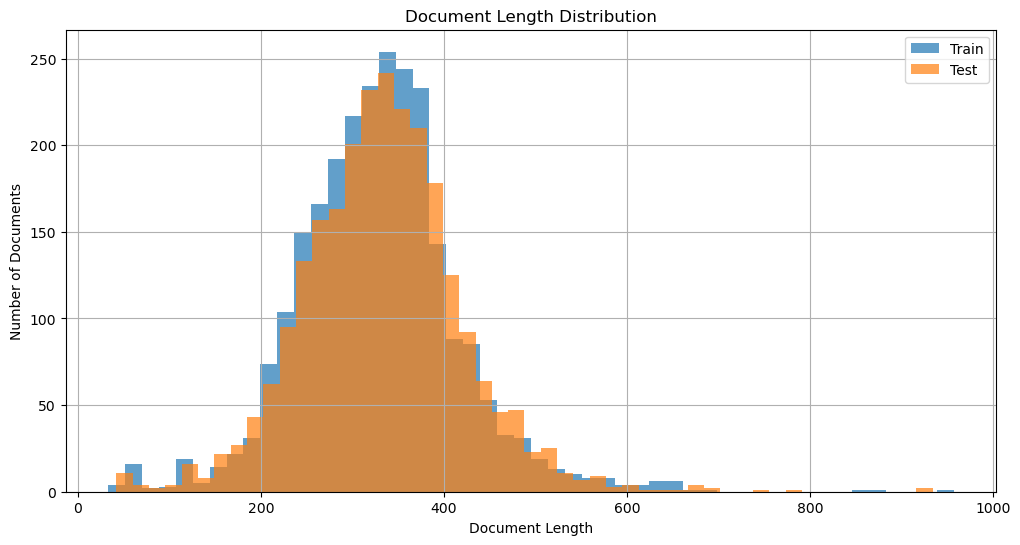

In [14]:
# Term Frequencies
all_tokens = [token for text in train_texts for token in preprocess_text(text)]
common_tokens = Counter(all_tokens).most_common(10)
print("\nMost common words across the training set:")
for token, freq in common_tokens:
    print(f"{token}: {freq}")

# Document Length Distribution
plt.figure(figsize=(12, 6))
plt.hist(train_doc_lengths, bins=50, alpha=0.7, label='Train')
plt.hist(test_doc_lengths, bins=50, alpha=0.7, label='Test')
plt.title('Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Number of Documents')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# The CountVectorizer will now use my custom tokenizer/preprocesser
vectorizer = CountVectorizer(tokenizer=preprocess_text, stop_words='english', max_features=2500)
train_dtm = vectorizer.fit_transform(train_texts)
test_dtm = vectorizer.transform(test_texts)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea'

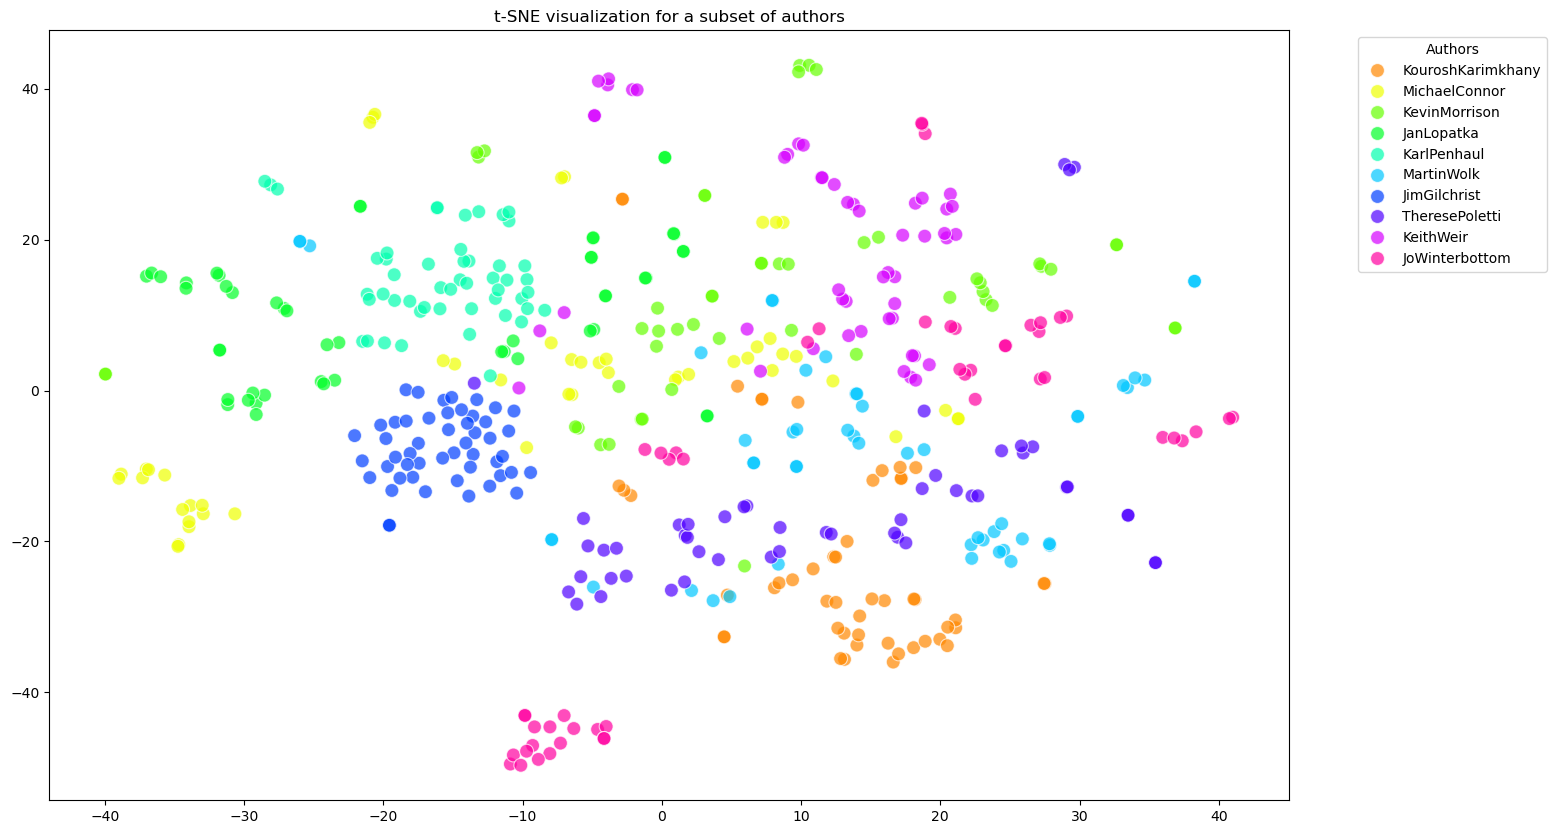

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import random

# 1. Choose a subset of 10 authors
unique_authors = list(set(train_labels))
selected_authors = random.sample(unique_authors, 10)

# 2. Filter the training data
filtered_indices = [i for i, label in enumerate(train_labels) if label in selected_authors]
filtered_texts = [train_texts[i] for i in filtered_indices]
filtered_labels = [train_labels[i] for i in filtered_indices]
filtered_dtm = train_dtm[filtered_indices]

# 3. PCA and t-SNE
pca = PCA(n_components=100)
reduced_data_pca = pca.fit_transform(filtered_dtm.toarray())  # Convert sparse matrix to dense matrix
tsne = TSNE(n_components=2, perplexity=20)
tsne_results = tsne.fit_transform(reduced_data_pca)

# 4. Plotting
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=filtered_labels,
    palette=sns.color_palette("hsv", len(selected_authors)),
    alpha=0.7,
    s=100
)
plt.title('t-SNE visualization for a subset of authors')
plt.legend(title='Authors', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()